In [1]:
%run ./utility.ipynb

# Loss
The Loss function is trying to compare the data with the image and see if they agree with each other.

Let $I(x,y)$ be the image and we transform it into $\hat{I} (x,y)$ by using fourier transfroms described in the the interpolate section of the previous notebook. 

Next we compare each interpolated point with its data term counterpart and get the equation for loss to be:

$$J = \sum_{i}\frac{|\hat{I}(u_i,v_i) - D_i|^2}{\sigma_i^2}$$

$\sigma$ here is the error for the $i^{th}$ data point.

Finally, we add the regularizer to the loss using the method in the previous notebook.

## Data Term calculation
We have above that $\hat{I}$ is in the Fourier Domain. In order to compute the data term, we calculate the term as $D = \text{Amp} * e^{i*\text{phase}}$.

It is important to note that the phase in Z is in radians, not degrees


In [2]:
def loss(image, data_list: list[data], coords, p = 2, reg_weight = 1, FOV = 100*u.uas.to(u.rad)):
    """
    calculates the loss of an image compared to the data given
    Args:
        image is a 80x80 pixel image that represents our reconstructed image
        coords is a list of u,v coordinates that we obtained from our data
        p is the kind of norm to be used
        reg_weight is the regularizer weight
        FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
    Returns:
        a loss value
    """
    error_sum = 0
    vis_images = interpolate(image, coords, FOV)
    
    for i in range(len(data_list)):
        vis_data = data_list[i].amp * np.exp(1j * math.radians(data_list[i].phase))
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data) / data_list[i].sigma) ** 2
        error_sum += error
    
    return error_sum + reg_weight * calc_regularizer(image=image, tsv=True, p=2)

## Furthermore into the data
What we are doing here is a simplified version of the loss function. In reality, the loss is more complicated due to other factors.

Because of the method of combining signal data from many telescopes, we get errors that may throw off the data terms. 

How would we change our loss function?

### Method One: Gain
We add a new function called the Gain which represents the telescoping errors. It is a smooth function in time that has a phase and amplitude. We multiply it with the data term to result in:

$$J = \sum_{i,j}(\frac{|\hat{I} - G D|^2}{\sigma^2})$$

Now when we try to minimize the image, we are also trying to minimize G.

### Method Two: Closure Phase
The other way is to take into the account the Closure Phase.

Using three telescopes we get:

$$ \sum_{i,j,k} (\frac{|\phi_{i,j} + \phi_{j,k} + \phi_{k,i} - \phi_{\hat{I}}|^2}{\sigma^2}) \text{ where }i \neq j \neq k$$

$\phi_{i,j} + \phi_{j,k} + \phi_{k,i}$ is called the Closure Phase $CP$ which is independent of the telescope error and is taken from the data. $\phi_{\hat{I}}$ is a Closure Phase computed from the image. 

In practice, these are the two major methods in order to fit the image to the data.

For the purposes of this notebook however we will be simplifying the problem and setting these visibilities to one.

## Testing the function
Below we have a image that was generated for testing purposes. Sometimes we want to shift the image in someway so that the loss function can be optimized further. In EHT, they have tested with many variations and come up with the loss being the best with the ring centered in the middle. We will test this claim below.

(-0.5, 79.5, 79.5, -0.5)

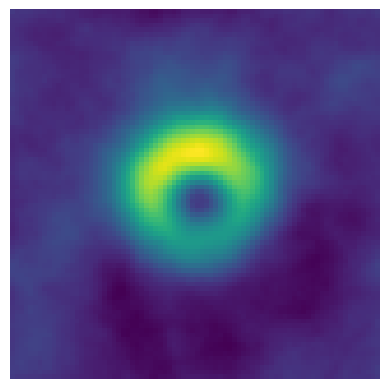

In [3]:
sample = np.loadtxt("images/data.csv", delimiter=",")
plt.figure()
plt.imshow(sample)
plt.axis('off')

Here we generate a coords and data_list list by sampling data from the ring (not the noise around the ring). 

In [4]:
def do_sample(n):
    """
    Collects n samples from a sample image
    Args:
        n is the number of samples as an integer
    Returns:
        a list of coordinates in u,v space
        a list of data objects
    """
    coords = []
    data_list = []
    ft_image = np.fft.fftshift(np.fft.fft2(sample))
    for i in range(n):
        coords.append((int(np.random.rand()*10-5), int(np.random.rand()*10-5)))
        data_list.append(data(coords[i][0], coords[i][1], 0, ft_image[coords[i][0]+40][coords[i][1]+40], 1))
    return coords, data_list

In [5]:
coords, data_list = do_sample(25)
data_list

[[u: 0, v: 4],
 [u: 1, v: -2],
 [u: 2, v: -4],
 [u: -4, v: 0],
 [u: -3, v: 0],
 [u: -3, v: -2],
 [u: 2, v: -1],
 [u: 3, v: 4],
 [u: -3, v: 2],
 [u: 2, v: 0],
 [u: -2, v: -3],
 [u: 0, v: -1],
 [u: 3, v: 1],
 [u: 2, v: 1],
 [u: 1, v: 4],
 [u: 3, v: 2],
 [u: 0, v: 3],
 [u: 1, v: 0],
 [u: 0, v: 4],
 [u: 0, v: 2],
 [u: 1, v: -3],
 [u: -3, v: -1],
 [u: -3, v: 0],
 [u: 1, v: -3],
 [u: 0, v: 3]]

It is important to note here that the data points in data_list is complex. Since we sampled from the fourier transform, we have no need to calcuate the data term like we do in the loss function above. Below is a altered version of the loss function above.

Finally, below we calcuate the loss of the sample image we started with and then shift the image in all directions. Then we plot the array of losses that we obtained.

In [6]:
def calculate_losses():
    """
    Calculates the losses of the image by shifting it around 
    Args:
        None
    Returns:
        an array of losses where the index is how much the image is shifted starting with -40 to 40
    """
    loss_arr = np.zeros((len(sample),len(sample[0])))
    for i in range(len(sample)):
        image_1 = np.roll(sample, i, axis=1) # Right shifts
        for j in range(len(sample[i])):
            image_2 = np.roll(image_1, j, axis = 0) # Up shifts
            loss_arr[i][j] = loss(image_2, data_list, coords, reg_weight=0, FOV=1)
            
    loss_arr1 = np.roll(loss_arr, 40, axis=1)
    loss_arr2 = np.roll(loss_arr1, 40, axis=0)

    plt.figure()
    plt.imshow(loss_arr2)
    plt.axis('off')
    return loss_arr

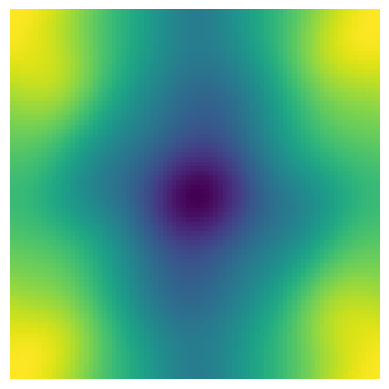

In [7]:
loss_arr = calculate_losses()

The dark spots in this picture are low points while the yellow spots are high points. Here we see that there are a few spots where the image produces low loss. If ran again, we will get differing behaviors

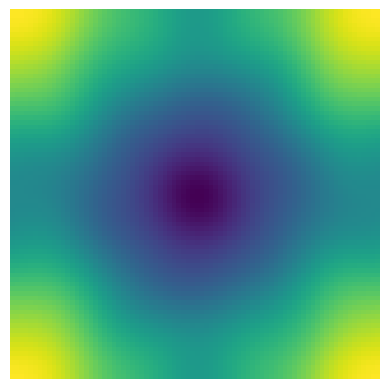

In [8]:
coords, data_list = do_sample(25)
loss_arr = calculate_losses()

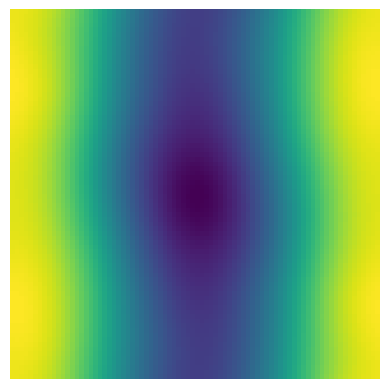

In [9]:
coords, data_list = do_sample(25)
loss_arr = calculate_losses()

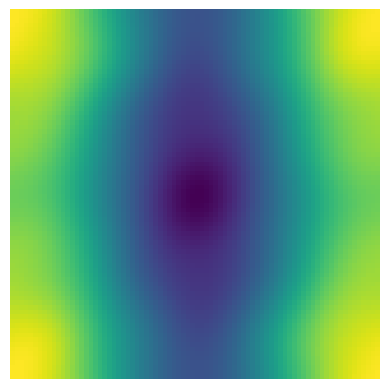

In [10]:
coords, data_list = do_sample(25)
loss_arr = calculate_losses()

In all four of these trials (and other reruns that we test), we generally see dark spots in the centers suggesting that the best area to put the ring is centered in the middle of the image